# Seasonal ARIMA forecasting on PV

## Import data

In [31]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np

from sktime.forecasting.arima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import DataRetriever as dr

import SARIMAX as arima

retriever = dr.DataRetriever()
#year1 = retriever.get_data("All-Subsystems-hour-Year1.pkl")
year2 = retriever.get_data("All-Subsystems-minute-Year2.pkl")

In [32]:
year2

Timestamp  TimeStamp_Count  \
Timestamp                                                  
2015-02-01 00:01:50 2015-02-01 00:01:50                1   
2015-02-01 00:02:50 2015-02-01 00:02:50                2   
2015-02-01 00:03:50 2015-02-01 00:03:50                3   
2015-02-01 00:04:50 2015-02-01 00:04:50                4   
2015-02-01 00:05:50 2015-02-01 00:05:50                5   
...                                 ...              ...   
2016-01-31 23:54:24 2016-01-31 23:54:24           519600   
2016-01-31 23:55:24 2016-01-31 23:55:24           519601   
2016-01-31 23:56:24 2016-01-31 23:56:24           519602   
2016-01-31 23:57:24 2016-01-31 23:57:24           519603   
2016-01-31 23:58:24 2016-01-31 23:58:24           519604   

                     Load_LatentHeatWaterVolume  Load_RefrigeratorTemp  \
Timestamp                                                                
2015-02-01 00:01:50                    0.000000               4.994715   
2015-02-01 00:02:50                    0.000000               5.046792   
2015-02-01 00:03:50                    0.000000               5.129493   
2015-02-01 00:04:50                    0.001981               5.163539   
2015-02-01 00:05:50                    0.001981               5.232744   
...                                         ...                    ...   
2016-01-31 23:54:24                    1.757590               4.512704   
2016-01-31 23:55:24                    1.760893               4.514255   
2016-01-31 23:56:24                    1.763535               4.548853   
2016-01-31 23:57:24                    1.763535               4.557287   
2016-01-31 23:58:24                    1.763535               4.589046   

                     Load_StatusBA1Lights  Load_StatusKitchenLightsA  \
Timestamp                                                              
2015-02-01 00:01:50                   0.0                        0.0   
2015-02-01 00:02:50                   0.0                        0.0   
2015-02-01 00:03:50                   0.0                        0.0   
2015-02-01 00:04:50                   0.0                        0.0   
2015-02-01 00:05:50                   0.0                        0.0   
...                                   ...                        ...   
2016-01-31 23:54:24                   0.0                        0.0   
2016-01-31 23:55:24                   0.0                        0.0   
2016-01-31 23:56:24                   0.0                        0.0   
2016-01-31 23:57:24                   0.0                        0.0   
2016-01-31 23:58:24                   0.0                        0.0   

                     Load_StatusKitchenLightsB  Load_StatusKitchenLightsC  \
Timestamp                                                                   
2015-02-01 00:01:50                        0.0                        0.0   
2015-02-01 00:02:50                        0.0                        0.0   
2015-02-01 00:03:50                        0.0                        0.0   
2015-02-01 00:04:50                        0.0                        0.0   
2015-02-01 00:05:50                        0.0                        0.0   
...                                        ...                        ...   
2016-01-31 23:54:24                        0.0                        0.0   
2016-01-31 23:55:24                        0.0                        0.0   
2016-01-31 23:56:24                        0.0                        0.0   
2016-01-31 23:57:24                        0.0                        0.0   
2016-01-31 23:58:24                        0.0                        0.0   

                     Load_StatusDRLights  Load_StatusLRLights3  ...  \
Timestamp                                                       ...   
2015-02-01 00:01:50                  0.0                   0.0  ...   
2015-02-01 00:02:50                  0.0                   0.0  ...   
2015-02-01 00:03:50                  0.0                   0.0 

In [33]:
extra_variable = year2['PV_PVInsolationHArray'].resample('h').sum()
extra_variable

Timestamp
2015-02-01 00:00:00    0.057408
2015-02-01 01:00:00    0.060286
2015-02-01 02:00:00    0.058811
2015-02-01 03:00:00    0.058865
2015-02-01 04:00:00    0.059288
                         ...   
2016-01-31 19:00:00    0.059872
2016-01-31 20:00:00    0.059688
2016-01-31 21:00:00    0.058976
2016-01-31 22:00:00    0.059878
2016-01-31 23:00:00    0.058991
Freq: H, Name: PV_PVInsolationHArray, Length: 8760, dtype: float64

In [34]:
# gen_year1 = year1[year1["PV_Watts3PhTotalW3PhT1"].isna() == False]
# gen_year1 = gen_year1[gen_year1["PV_Watts3PhTotalW3PhT2"].isna() == False] #There are 87 rows with NaN values.
#
# print(f"A total of {len(year1) - len(gen_year1)} rows have been dropped since they have NaN values.")
#
# gen_year1["Generated Energy"] = (gen_year1["PV_Watts3PhTotalW3PhT1"].to_numpy() + gen_year1["PV_Watts3PhTotalW3PhT2"].to_numpy())
# gen_year1 = gen_year1[["Generated Energy"]] / 1e3 #Convert Wh to kWh
# gen_year1

In [35]:
gen_year2 = year2[year2["PV_Watts3PhTotalW3PhT1"].isna() == False]
gen_year2 = gen_year2[gen_year2["PV_Watts3PhTotalW3PhT2"].isna() == False] #There are 87 rows with NaN values.

print(f"A total of {len(year2) - len(gen_year2)} rows have been dropped since they have NaN values.")

gen_year2["Generated Energy"] = (gen_year2["PV_Watts3PhTotalW3PhT1"].to_numpy() + gen_year2["PV_Watts3PhTotalW3PhT2"].to_numpy())
gen_year2 = gen_year2[["Generated Energy"]] / 1e3 #Convert Wh to kWh
gen_year2

A total of 0 rows have been dropped since they have NaN values.


Generated Energy
Timestamp                            
2015-02-01 00:01:50          0.018532
2015-02-01 00:02:50          0.018293
2015-02-01 00:03:50          0.018539
2015-02-01 00:04:50          0.018576
2015-02-01 00:05:50          0.018546
...                               ...
2016-01-31 23:54:24          0.018296
2016-01-31 23:55:24          0.018370
2016-01-31 23:56:24          0.018222
2016-01-31 23:57:24          0.018258
2016-01-31 23:58:24          0.018384

[519604 rows x 1 columns]

In [36]:
# gen_df = pd.concat([gen_year1, gen_year2])
# gen_df

In [37]:
gen_df = gen_year2

gen_df = gen_df.resample('h').sum()
gen_df

Generated Energy
Timestamp                            
2015-02-01 00:00:00          1.091283
2015-02-01 01:00:00          1.099894
2015-02-01 02:00:00          1.103079
2015-02-01 03:00:00          1.110093
2015-02-01 04:00:00          1.111437
...                               ...
2016-01-31 19:00:00          1.062589
2016-01-31 20:00:00          1.076417
2016-01-31 21:00:00          1.088920
2016-01-31 22:00:00          1.092549
2016-01-31 23:00:00          1.078689

[8760 rows x 1 columns]

In [38]:
fig = go.Figure(go.Scattergl(
    x = gen_df.index,
    y = gen_df["Generated Energy"]
))

fig.show()

## Check if PV is stationary

In [62]:
from statsmodels.tsa.stattools import adfuller

#Null hypothesis is that TS is non-stationary.

test = adfuller(gen_df["Generated Energy"])

print(f"The p-value from the Augmented Dickey-Fuller test is {test[1]}. \n This indicates that the time series is already stationary.")

The p-value from the Augmented Dickey-Fuller test is 4.568326275912422e-19. 
 This indicates that the time series is already stationary


In [40]:
gen_df['1dif'] = gen_df["Generated Energy"] - gen_df["Generated Energy"].shift(1)
gen_df['2dif'] = gen_df["Generated Energy"] - gen_df["Generated Energy"].shift(2)
gen_df['3dif'] = gen_df["Generated Energy"] - gen_df["Generated Energy"].shift(3)

# gen_df

Generated Energy      1dif      2dif       3dif
Timestamp                                                           
2015-02-01 00:00:00          1.091283       NaN       NaN        NaN
2015-02-01 01:00:00          1.099894  0.008611       NaN        NaN
2015-02-01 02:00:00          1.103079  0.003185  0.011795        NaN
2015-02-01 03:00:00          1.110093  0.007014  0.010199   0.018809
2015-02-01 04:00:00          1.111437  0.001345  0.008358   0.011543
...                               ...       ...       ...        ...
2016-01-31 19:00:00          1.062589  0.017272 -2.298890 -42.996002
2016-01-31 20:00:00          1.076417  0.013828  0.031100  -2.285062
2016-01-31 21:00:00          1.088920  0.012503  0.026330   0.043602
2016-01-31 22:00:00          1.092549  0.003630  0.016132   0.029960
2016-01-31 23:00:00          1.078689 -0.013860 -0.010230   0.002273

[8760 rows x 4 columns]

In [61]:
fig = go.Figure(go.Scattergl(
    x = gen_df.index,
    y = gen_df['Generated Energy']
))

fig.show()

# Determine order of differincing (d)

Lets say we pick d=1


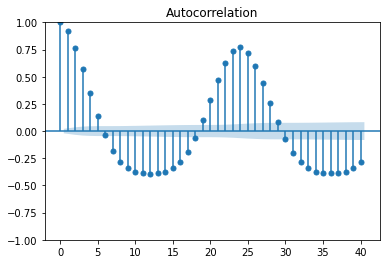

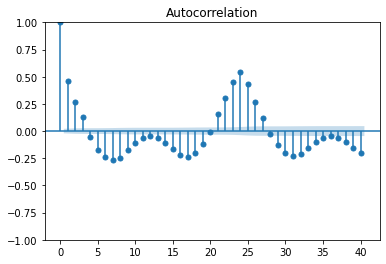

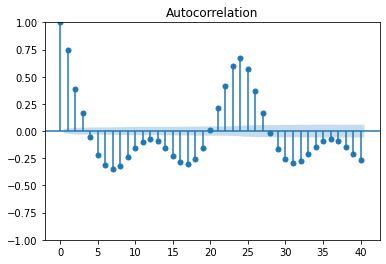

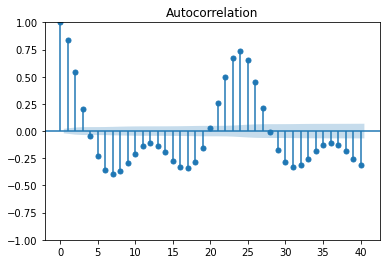

In [44]:
#Is done checking the autocorrelation plots (ACF)

autocorrelation_no_difference = plot_acf(gen_df["Generated Energy"].dropna())
autocorrelation_first_difference = plot_acf(gen_df["1dif"].dropna())
autocorrelation_second_difference = plot_acf(gen_df["2dif"].dropna())
autocorrelation_third_difference = plot_acf(gen_df["3dif"].dropna())

print(f"Lets say we pick d=1")

# Determine order of autoregressive terms (p)

p = 4


c:\users\magnu\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



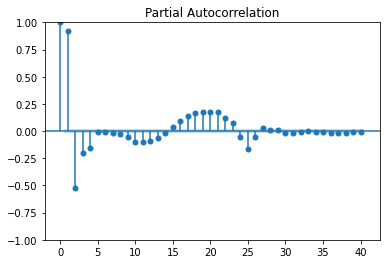

In [75]:
import matplotlib.pyplot as plt
#This is done using the partial autocorrelation (PACF) plots

partialautocorrelation_no_difference = plot_pacf(gen_df['Generated Energy'].dropna())
#partialautocorrelation_first_difference = plot_pacf(gen_df['1dif'].dropna())
#partialautocorrelation_second_difference = plot_pacf(gen_df['2dif'].dropna())
#partialautocorrelation_third_difference = plot_pacf(gen_df['3dif'].dropna())

print("p = 4")

### Determine order of moving average terms (q)

q = 5


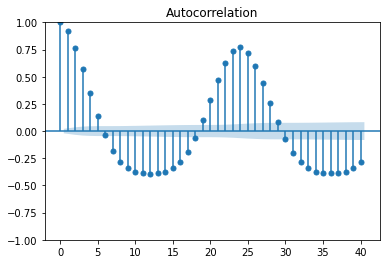

In [64]:
autocorrelation_no_difference = plot_acf(gen_df["Generated Energy"].dropna())
#autocorrelation_first_difference = plot_acf(gen_df["1dif"].dropna())

print("q = 5")

## Calculate seasonal difference

In [47]:
# We have 4 quarters over the year

gen_df["Seasonal Difference"] = gen_df["Generated Energy"] - gen_df["Generated Energy"].shift(2)
gen_df

Generated Energy      1dif      2dif       3dif  \
Timestamp                                                              
2015-02-01 00:00:00          1.091283       NaN       NaN        NaN   
2015-02-01 01:00:00          1.099894  0.008611       NaN        NaN   
2015-02-01 02:00:00          1.103079  0.003185  0.011795        NaN   
2015-02-01 03:00:00          1.110093  0.007014  0.010199   0.018809   
2015-02-01 04:00:00          1.111437  0.001345  0.008358   0.011543   
...                               ...       ...       ...        ...   
2016-01-31 19:00:00          1.062589  0.017272 -2.298890 -42.996002   
2016-01-31 20:00:00          1.076417  0.013828  0.031100  -2.285062   
2016-01-31 21:00:00          1.088920  0.012503  0.026330   0.043602   
2016-01-31 22:00:00          1.092549  0.003630  0.016132   0.029960   
2016-01-31 23:00:00          1.078689 -0.013860 -0.010230   0.002273   

                     Seasonal Difference  
Timestamp                                 
2015-02-01 00:00:00                  NaN  
2015-02-01 01:00:00                  NaN  
2015-02-01 02:00:00             0.011795  
2015-02-01 03:00:00             0.010199  
2015-02-01 04:00:00             0.008358  
...                                  ...  
2016-01-31 19:00:00            -2.298890  
2016-01-31 20:00:00             0.031100  
2016-01-31 21:00:00             0.026330  
2016-01-31 22:00:00             0.016132  
2016-01-31 23:00:00            -0.010230  

[8760 rows x 5 columns]

In [48]:
fig = go.Figure(go.Scatter(
    x = gen_df.index,
    y = gen_df["Seasonal Difference"]
))

fig.show()

In [49]:
test = adfuller(gen_df["Seasonal Difference"].dropna())

print(f"The p value for the seasonal difference is {test[1]}.\nThis suggest D=0.")

The p value for the seasonal difference is 0.0.
This suggest D=0.


## Autocorrelation & Partial Autocorrelation

### Seasonal difference (D)

c:\users\magnu\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



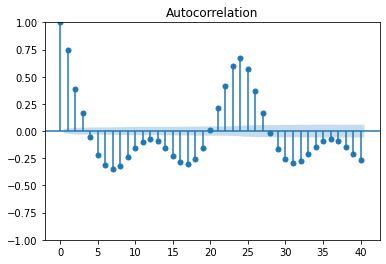

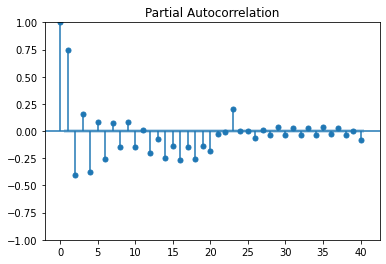

In [50]:
autocorrelation_seasonal_difference = plot_acf(gen_df["Seasonal Difference"].dropna())

partialautocorrelation_seasonal_difference = plot_pacf(gen_df['Seasonal Difference'].dropna())

## ARIMA model

In [51]:
train_df = gen_df[0:8698]
train_df

Generated Energy       1dif       2dif       3dif  \
Timestamp                                                                
2015-02-01 00:00:00          1.091283        NaN        NaN        NaN   
2015-02-01 01:00:00          1.099894   0.008611        NaN        NaN   
2015-02-01 02:00:00          1.103079   0.003185   0.011795        NaN   
2015-02-01 03:00:00          1.110093   0.007014   0.010199   0.018809   
2015-02-01 04:00:00          1.111437   0.001345   0.008358   0.011543   
...                               ...        ...        ...        ...   
2016-01-29 05:00:00          1.087609  -0.006955   0.004666  -0.001857   
2016-01-29 06:00:00          1.097332   0.009723   0.002768   0.014389   
2016-01-29 07:00:00          4.951367   3.854035   3.863758   3.856803   
2016-01-29 08:00:00         42.061987  37.110621  40.964655  40.974379   
2016-01-29 09:00:00         43.148774   1.086787  38.197407  42.051442   

                     Seasonal Difference  
Timestamp                                 
2015-02-01 00:00:00                  NaN  
2015-02-01 01:00:00                  NaN  
2015-02-01 02:00:00             0.011795  
2015-02-01 03:00:00             0.010199  
2015-02-01 04:00:00             0.008358  
...                                  ...  
2016-01-29 05:00:00             0.004666  
2016-01-29 06:00:00             0.002768  
2016-01-29 07:00:00             3.863758  
2016-01-29 08:00:00            40.964655  
2016-01-29 09:00:00            38.197407  

[8698 rows x 5 columns]

In [52]:
test_df = gen_df[8698:8760]
test_df

Generated Energy        1dif        2dif        3dif  \
Timestamp                                                                   
2016-01-29 10:00:00        286.835075  243.686301  244.773088  281.883708   
2016-01-29 11:00:00        319.224565   32.389490  276.075791  277.162578   
2016-01-29 12:00:00        166.684097 -152.540468 -120.150977  123.535324   
2016-01-29 13:00:00        446.829679  280.145581  127.605114  159.994604   
2016-01-29 14:00:00        230.659196 -216.170483   63.975099  -88.565369   
...                               ...         ...         ...         ...   
2016-01-31 19:00:00          1.062589    0.017272   -2.298890  -42.996002   
2016-01-31 20:00:00          1.076417    0.013828    0.031100   -2.285062   
2016-01-31 21:00:00          1.088920    0.012503    0.026330    0.043602   
2016-01-31 22:00:00          1.092549    0.003630    0.016132    0.029960   
2016-01-31 23:00:00          1.078689   -0.013860   -0.010230    0.002273   

                     Seasonal Difference  
Timestamp                                 
2016-01-29 10:00:00           244.773088  
2016-01-29 11:00:00           276.075791  
2016-01-29 12:00:00          -120.150977  
2016-01-29 13:00:00           127.605114  
2016-01-29 14:00:00            63.975099  
...                                  ...  
2016-01-31 19:00:00            -2.298890  
2016-01-31 20:00:00             0.031100  
2016-01-31 21:00:00             0.026330  
2016-01-31 22:00:00             0.016132  
2016-01-31 23:00:00            -0.010230  

[62 rows x 5 columns]

In [79]:
from sktime.forecasting.arima import ARIMA

model=ARIMA(order=(4, 1, 5), seasonal_order=(0, 0, 0, 0), supress_warnings=True)
result=model.fit(y=train_df['Generated Energy'])

c:\users\magnu\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### Forecasting

In [54]:
train_df

Generated Energy       1dif       2dif       3dif  \
2015-02-01 00:00:00          1.091283        NaN        NaN        NaN   
2015-02-01 01:00:00          1.099894   0.008611        NaN        NaN   
2015-02-01 02:00:00          1.103079   0.003185   0.011795        NaN   
2015-02-01 03:00:00          1.110093   0.007014   0.010199   0.018809   
2015-02-01 04:00:00          1.111437   0.001345   0.008358   0.011543   
...                               ...        ...        ...        ...   
2016-01-29 05:00:00          1.087609  -0.006955   0.004666  -0.001857   
2016-01-29 06:00:00          1.097332   0.009723   0.002768   0.014389   
2016-01-29 07:00:00          4.951367   3.854035   3.863758   3.856803   
2016-01-29 08:00:00         42.061987  37.110621  40.964655  40.974379   
2016-01-29 09:00:00         43.148774   1.086787  38.197407  42.051442   

                     Seasonal Difference  
2015-02-01 00:00:00                  NaN  
2015-02-01 01:00:00                  NaN  
2015-02-01 02:00:00             0.011795  
2015-02-01 03:00:00             0.010199  
2015-02-01 04:00:00             0.008358  
...                                  ...  
2016-01-29 05:00:00             0.004666  
2016-01-29 06:00:00             0.002768  
2016-01-29 07:00:00             3.863758  
2016-01-29 08:00:00            40.964655  
2016-01-29 09:00:00            38.197407  

[8698 rows x 5 columns]

In [55]:
predictions = result.predict(fh=[x for x in range(0, 74)])

c:\users\magnu\appdata\local\programs\python\python39\lib\site-packages\sktime\forecasting\base\_fh.py:100: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

c:\users\magnu\appdata\local\programs\python\python39\lib\site-packages\sktime\forecasting\base\_fh.py:337: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

c:\users\magnu\appdata\local\programs\python\python39\lib\site-packages\sktime\forecasting\base\adapters\_pmdarima.py:110: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

c:\users\magnu\appdata\local\programs\python\python39\lib\site-packages\sktime\utils\datetime.py:77: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

c:\users\magnu\appdata\local\programs\python\python39\lib\site

In [56]:
predictions

2016-01-29 09:00:00    58.069142
2016-01-29 10:00:00    44.743570
2016-01-29 11:00:00    42.978882
2016-01-29 12:00:00    44.778410
2016-01-29 13:00:00    46.280031
                         ...    
2016-02-01 06:00:00    53.693111
2016-02-01 07:00:00    53.690283
2016-02-01 08:00:00    53.687453
2016-02-01 09:00:00    53.684621
2016-02-01 10:00:00    53.681789
Length: 74, dtype: float64

In [57]:
gen_df['Prediction'] = predictions
gen_df

Generated Energy      1dif      2dif       3dif  \
Timestamp                                                              
2015-02-01 00:00:00          1.091283       NaN       NaN        NaN   
2015-02-01 01:00:00          1.099894  0.008611       NaN        NaN   
2015-02-01 02:00:00          1.103079  0.003185  0.011795        NaN   
2015-02-01 03:00:00          1.110093  0.007014  0.010199   0.018809   
2015-02-01 04:00:00          1.111437  0.001345  0.008358   0.011543   
...                               ...       ...       ...        ...   
2016-01-31 19:00:00          1.062589  0.017272 -2.298890 -42.996002   
2016-01-31 20:00:00          1.076417  0.013828  0.031100  -2.285062   
2016-01-31 21:00:00          1.088920  0.012503  0.026330   0.043602   
2016-01-31 22:00:00          1.092549  0.003630  0.016132   0.029960   
2016-01-31 23:00:00          1.078689 -0.013860 -0.010230   0.002273   

                     Seasonal Difference  Prediction  
Timestamp                                             
2015-02-01 00:00:00                  NaN         NaN  
2015-02-01 01:00:00                  NaN         NaN  
2015-02-01 02:00:00             0.011795         NaN  
2015-02-01 03:00:00             0.010199         NaN  
2015-02-01 04:00:00             0.008358         NaN  
...                                  ...         ...  
2016-01-31 19:00:00            -2.298890   53.723952  
2016-01-31 20:00:00             0.031100   53.721186  
2016-01-31 21:00:00             0.026330   53.718409  
2016-01-31 22:00:00             0.016132   53.715621  
2016-01-31 23:00:00            -0.010230   53.712825  

[8760 rows x 6 columns]

In [58]:
fig = go.Figure(go.Scattergl(
    x = gen_df.index,
    y = gen_df['Generated Energy']
))

fig.add_trace(go.Scattergl(
    x = gen_df.index,
    y = gen_df['Prediction'])
)

fig.show()

#test_df[['Generated Energy', 'Prediction']].plot()